In [13]:
import dask.dataframe as dd
from fbprophet import Prophet
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

In [14]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [15]:
%%time

# set parquet data folder path
parquet_data_folder = '../data/crimes-2001-to-present.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 7.38 s


In [16]:
# get homicides stats
crime_types = crimes[['PrimaryType']]
homicides = crime_types[(crime_types['PrimaryType']=='HOMICIDE')]
print(homicides.resample('M').count().compute())

            PrimaryType
2001-01-31           42
2001-02-28           26
2001-03-31           37
2001-04-30           59
2001-05-31           42
2001-06-30           68
2001-07-31           78
2001-08-31           56
2001-09-30           70
2001-10-31           69
2001-11-30           61
2001-12-31           49
2002-01-31           44
2002-02-28           31
2002-03-31           41
2002-04-30           43
2002-05-31           51
2002-06-30           65
2002-07-31           67
2002-08-31           77
2002-09-30           67
2002-10-31           57
2002-11-30           38
2002-12-31           70
2003-01-31           37
2003-02-28           31
2003-03-31           52
2003-04-30           57
2003-05-31           59
2003-06-30           51
...                 ...
2015-03-31           32
2015-04-30           35
2015-05-31           48
2015-06-30           48
2015-07-31           53
2015-08-31           53
2015-09-30           65
2015-10-31           32
2015-11-30           39
2015-12-31      

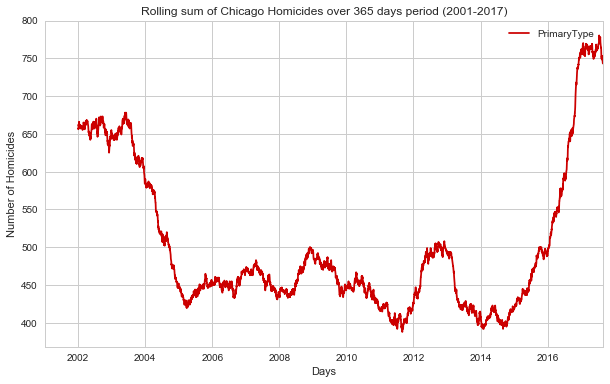

In [17]:
# get crimes rolling sum for a smoother crime chart display
crimes_rolling_sum = homicides.resample('D').count().rolling(365).sum().compute()
crimes_rolling_sum.plot(figsize=(10,6), color='#cc0000')
plt.title('Rolling sum of Chicago Homicides over 365 days period (2001-2017)')
plt.xlabel('Days')
plt.ylabel('Number of Homicides')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [23]:
daily_homicides = homicides.resample('D').count().compute()
daily_homicides = daily_homicides.rename(columns={'PrimaryType': 'y'})
daily_homicides['ds'] = daily_homicides.index.values
daily_homicides.head()

,y,ds
2001-01-01,2,2001-01-01
2001-01-02,0,2001-01-02
2001-01-03,0,2001-01-03
2001-01-04,2,2001-01-04
2001-01-05,1,2001-01-05


In [27]:
homicides_model = Prophet()
homicides_model.fit(daily_homicides)
future_homicides = homicides_model.make_future_dataframe(periods=365)
future_homicides.tail()

,ds
6441,2018-08-21
6442,2018-08-22
6443,2018-08-23
6444,2018-08-24
6445,2018-08-25


In [28]:
homicides_forecast = homicides_model.predict(future_homicides)
homicides_forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
6441,2018-08-21,1.059375,2.320272,0.138166,0.138166,2.303458,2.335682,0.928494,4.149854,-0.164419,-0.164419,-0.164419,0.302585,0.302585,0.302585,0.138166,2.458438
6442,2018-08-22,1.059539,2.320963,0.121441,0.121441,2.304057,2.336473,0.892294,4.160182,-0.177177,-0.177177,-0.177177,0.298618,0.298618,0.298618,0.121441,2.442403
6443,2018-08-23,1.059704,2.321653,0.174452,0.174452,2.304625,2.337256,0.831455,4.165432,-0.119737,-0.119737,-0.119737,0.294189,0.294189,0.294189,0.174452,2.496105
6444,2018-08-24,1.059868,2.322343,0.177598,0.177598,2.305194,2.338025,0.778217,4.115886,-0.111783,-0.111783,-0.111783,0.289381,0.289381,0.289381,0.177598,2.499941
6445,2018-08-25,1.060033,2.323034,0.579377,0.579377,2.305756,2.338794,1.266409,4.510802,0.295092,0.295092,0.295092,0.284285,0.284285,0.284285,0.579377,2.902410


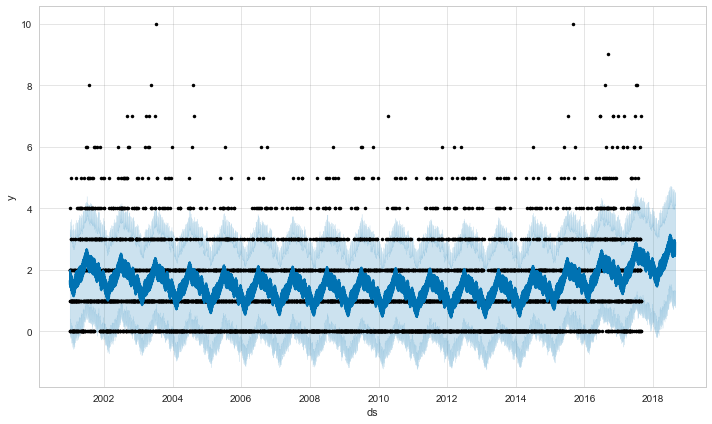

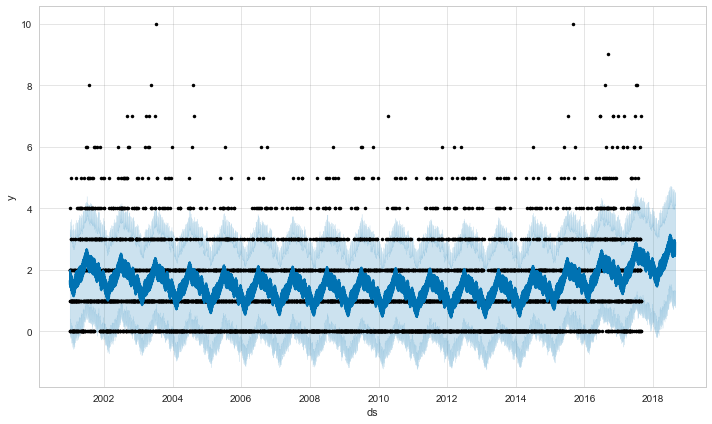

In [29]:
homicides_model.plot(homicides_forecast)

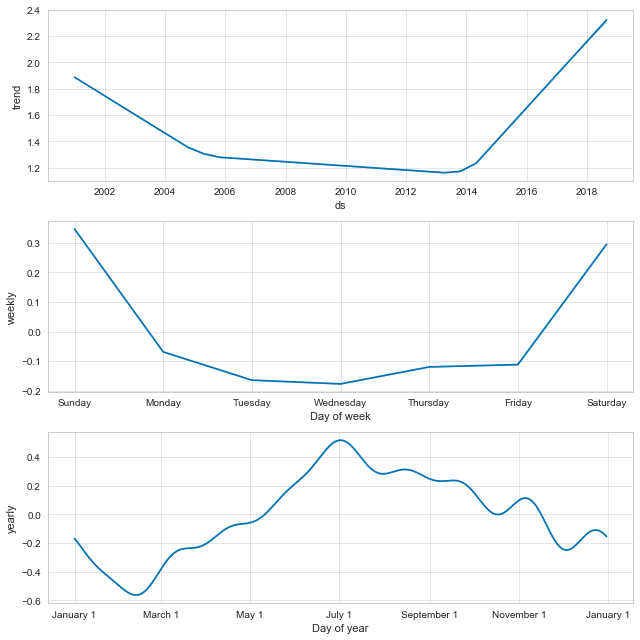

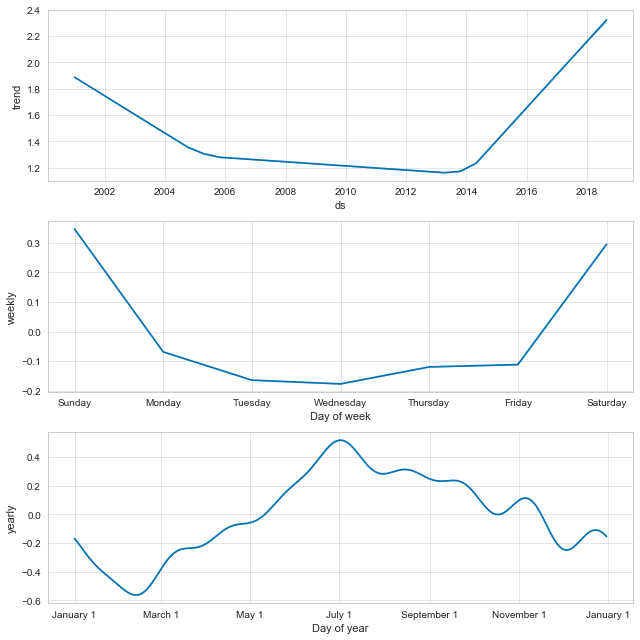

In [31]:
homicides_model.plot_components(homicides_forecast)